# Boston Housing Data Set

#### We will be predicting:
1. NOX (nitric oxides concentration)
2. median home value

## Getting Data

#### The data was cleaned and transformed into a csv file (please see clean_data.py file for details). h

#### houses.csv is now ready to be loaded.

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sklearn

'''
The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

Variables in order:
CRIM     per capita crime rate by town
ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS    proportion of non-retail business acres per town
CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX      nitric oxides concentration (parts per 10 million)
RM       average number of rooms per dwelling
AGE      proportion of owner-occupied units built prior to 1940
DIS      weighted distances to five Boston employment centres
RAD      index of accessibility to radial highways
TAX      full-value property-tax rate per $10,000
PTRATIO  pupil-teacher ratio by town
B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
LSTAT    % lower status of the population
MEDV     Median value of owner-occupied homes in $1000's
'''

cwd = os.getcwd()

HOUSES_PATH = os.path.join(cwd, "houses.csv")

data = pd.read_csv(HOUSES_PATH) 
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


#### We can see from above that our data set is fairly small (n=506). We want to cross-validate our models to verify the results.

## Cleaning Data

#### Our data seems to not be missing any values (no null values) and seems to be fairly clean. 

In [104]:
data.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

#### Let's check for data types (see if we need to change any categorical variables). It seems like there are not unconverted categorical variables (CHAS is already a dummy variable).

In [105]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null int64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


#### One note regarding the data: based on the histograms below, it seems like the data is farily skewed and there exists some outliers in the data. We need to standardize the data to make it more normally distributed and we should also regularize to get the values of the features to be similar to each other (will do both later). 

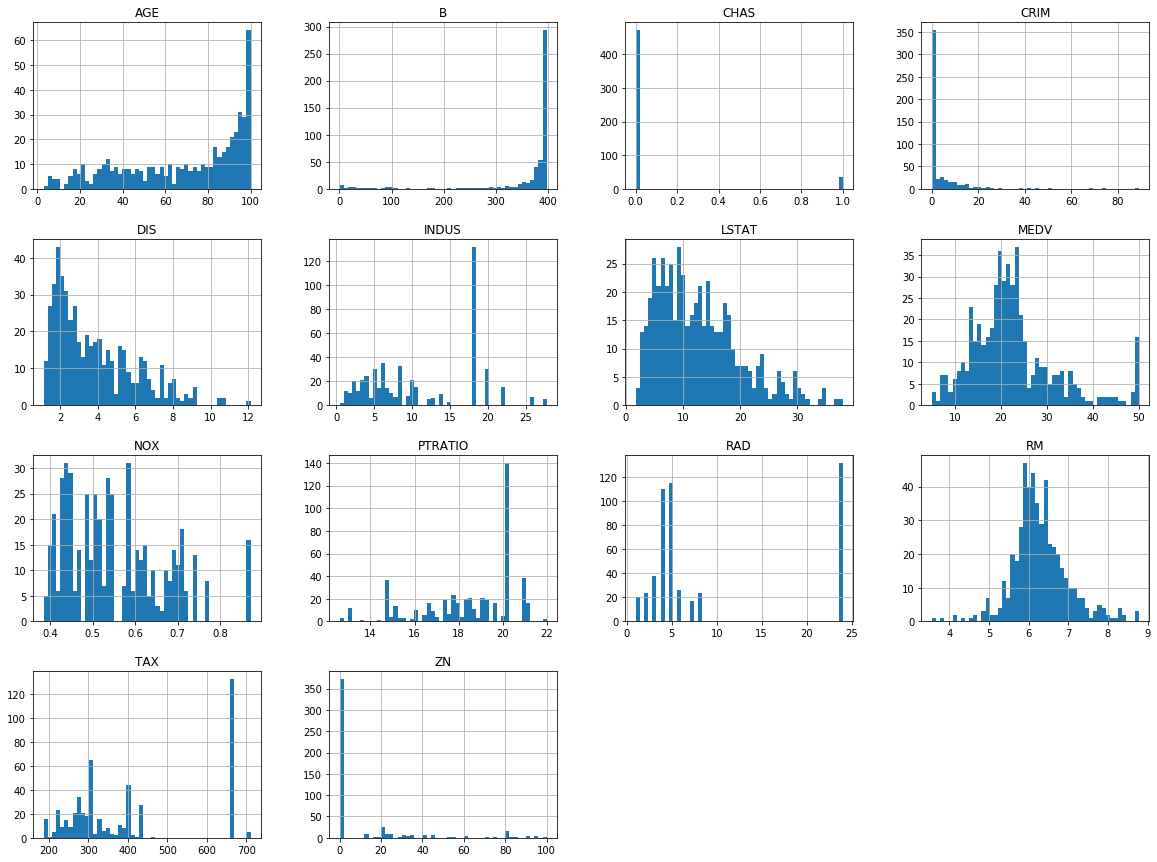

In [106]:
data.hist(bins=50, figsize=(20,15))
plt.show()

# NOX Prediction

## Feature Selection

#### Let's select what data sets/features we should include in our models. 


In [107]:
nox = data.copy()
corr_matrix = nox.corr()
corr_matrix["NOX"].sort_values(ascending=False)

NOX        1.000000
INDUS      0.763651
AGE        0.731470
TAX        0.668023
RAD        0.611441
LSTAT      0.590879
CRIM       0.420972
PTRATIO    0.188933
CHAS       0.091203
RM        -0.302188
B         -0.380051
MEDV      -0.427321
ZN        -0.516604
DIS       -0.769230
Name: NOX, dtype: float64

#### Based on the correlation matrix above, we can see that there are several features that are highly correlated to NOX. Let's try two types of data sets with the following features:
1. All features
2. INDUS, AGE, TAX, RAD, LSTAT, CRIM, MEDV, ZN, DIS (so we drop PTRATIO, CHAS, RM, B)

In [108]:
nox_y = nox['NOX']
nox_1 = nox.drop(columns=["NOX"])
nox_2 = nox.drop(columns=["PTRATIO", "CHAS", "RM", "B", "NOX"])

nox_data = [nox_1, nox_2]

## Train-Test Split

In [109]:
from sklearn.model_selection import train_test_split

nox_train, nox_test = train_test_split(nox, test_size=0.2, random_state=32)

nox_train_y = nox_train["NOX"]
train_1 = nox_train.drop(columns=["NOX"])
train_2 = nox_train.drop(columns=["NOX","PTRATIO", "CHAS", "RM", "B"])

nox_test_y = nox_test["NOX"]
test_1 = nox_test.drop(columns=["NOX"])
test_2 = nox_test.drop(columns=["PTRATIO", "CHAS", "RM", "B", "NOX"])


nox_train_array = [train_1, train_2]
nox_test_array = [test_1, test_2]


### Data Regularization

#### As discussed in the data clean up section, we regularize the data to normalize the distribution and scale the data.

In [110]:
from sklearn.preprocessing import StandardScaler

process = StandardScaler()

for data_set in nox_train_array:
    data_set = process.fit_transform(data_set)

## Models

#### First, we'll write a function to evaluate all our models. This function returns the correct output within a certain acceptable range as well as the Mean Average Error.

#### The acceptable range will be a standard deviation of the NOX value found in the original data set.

In [158]:
def evaluating_model(predictions, actual, acceptable_range, print_res = True):
    total = len(predictions)
    correct = 0
    mae = 0
    
    for i in range(total):
        difference = abs(predictions[i] - actual[i])
        if difference <= acceptable_range:
            correct += 1
        mae += difference
    
    percent_correct = (correct / total) * 100
    mae = mae / total
    
    if print_res:
        print("{:0.2f}% correct within {} parts per 10 million ({} correct guesses)".format(
                percent_correct, acceptable_range, correct))
        print("MAE: {:0.3f}".format(mae))
    return mae
        

### Linear Regression

In [159]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

count = 1
lin_array = []

for i in range(len(nox_train_array)):
    model_name = "Linear Regression {}".format(count)
    lin_reg = LinearRegression()
    lin_reg.fit(nox_train_array[i], nox_train_y)

    predicted = lin_reg.predict(nox_test_array[i])

    mse = mean_squared_error(nox_test_y, predicted)
    rmse = np.sqrt(mse)

    print("Linear Reg {} mse is {:.5f}, rmse is {:.3f}".format(count, mse, rmse))
    evaluating_model(predicted, nox_test_y.values, 0.05)
    evaluating_model(predicted, nox_test_y.values, 0.1)
    count +=1
    lin_array.append((model_name, lin_reg))
    print()


Linear Reg 1 mse is 0.00248, rmse is 0.050
68.63% correct within 0.05 parts per 10 million (70 correct guesses)
MAE: 0.038
94.12% correct within 0.1 parts per 10 million (96 correct guesses)
MAE: 0.038

Linear Reg 2 mse is 0.00238, rmse is 0.049
76.47% correct within 0.05 parts per 10 million (78 correct guesses)
MAE: 0.035
96.08% correct within 0.1 parts per 10 million (98 correct guesses)
MAE: 0.035



### Ridge Regression

In [160]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

count = 1
ridge_array = []

for i in range(len(nox_train_array)):
    model_name = "Ridge Regression{}".format(count)
    ridge_reg = Ridge(alpha=1, solver="cholesky")
    ridge_reg.fit(nox_train_array[i], nox_train_y)

    predicted = ridge_reg.predict(nox_test_array[i])

    mse = mean_squared_error(nox_test_y, predicted)
    rmse = np.sqrt(mse)

    print("Ridge Reg {} mse is {:.5f}, rmse is {:.3f}".format(count, mse, rmse))
    evaluating_model(predicted, nox_test_y.values, 0.05)
    evaluating_model(predicted, nox_test_y.values, 0.1)
    count +=1
    ridge_array.append((model_name, ridge_reg))
    print()




Ridge Reg 1 mse is 0.00248, rmse is 0.050
68.63% correct within 0.05 parts per 10 million (70 correct guesses)
MAE: 0.038
94.12% correct within 0.1 parts per 10 million (96 correct guesses)
MAE: 0.038

Ridge Reg 2 mse is 0.00238, rmse is 0.049
76.47% correct within 0.05 parts per 10 million (78 correct guesses)
MAE: 0.035
96.08% correct within 0.1 parts per 10 million (98 correct guesses)
MAE: 0.035



### Elastic Net Regression

In [161]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

count = 1
elastic_array = []

for i in range(len(nox_train_array)):
    model_name = "Elastic Regression{}".format(count)
    elas_reg = ElasticNet(alpha=0.2, l1_ratio=0.5)
    elas_reg.fit(nox_train_array[i], nox_train_y)

    predicted = elas_reg.predict(nox_test_array[i])

    mse = mean_squared_error(nox_test_y, predicted)
    rmse = np.sqrt(mse)

    print("Elastic Reg {} mse is {:.5f}, rmse is {:.3f}".format(count, mse, rmse))
    evaluating_model(predicted, nox_test_y.values, 0.05)
    evaluating_model(predicted, nox_test_y.values, 0.1)
    count +=1
    elastic_array.append((model_name, elas_reg))
    print()



Elastic Reg 1 mse is 0.00295, rmse is 0.054
73.53% correct within 0.05 parts per 10 million (75 correct guesses)
MAE: 0.038
96.08% correct within 0.1 parts per 10 million (98 correct guesses)
MAE: 0.038

Elastic Reg 2 mse is 0.00307, rmse is 0.055
72.55% correct within 0.05 parts per 10 million (74 correct guesses)
MAE: 0.039
96.08% correct within 0.1 parts per 10 million (98 correct guesses)
MAE: 0.039



### Lasso Regression

In [162]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

count = 1
lasso_array = []

for i in range(len(nox_train_array)):
    model_name = "Lasso Regression{}".format(count)
    lasso_reg = Lasso(alpha=0.1)
    lasso_reg.fit(nox_train_array[i], nox_train_y)

    predicted = lasso_reg.predict(nox_test_array[i])

    mse = mean_squared_error(nox_test_y, predicted)
    rmse = np.sqrt(mse)

    print("Lasso Reg {} mse is {:.5f}, rmse is {:.3f}".format(count, mse, rmse))
    evaluating_model(predicted, nox_test_y.values, 0.05)
    evaluating_model(predicted, nox_test_y.values, 0.1)
    count +=1
    lasso_array.append((model_name, lasso_reg))
    print()




Lasso Reg 1 mse is 0.00295, rmse is 0.054
73.53% correct within 0.05 parts per 10 million (75 correct guesses)
MAE: 0.038
96.08% correct within 0.1 parts per 10 million (98 correct guesses)
MAE: 0.038

Lasso Reg 2 mse is 0.00307, rmse is 0.055
72.55% correct within 0.05 parts per 10 million (74 correct guesses)
MAE: 0.039
96.08% correct within 0.1 parts per 10 million (98 correct guesses)
MAE: 0.039



### Decision Trees

#### Let's try using a decision tree.

In [163]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth=5, criterion='mae')

count = 1
tree_array = []

for i in range(len(nox_train_array)):
    model_name = "decision_tree_reg{}".format(count)
    tree_reg = DecisionTreeRegressor(max_depth=5, criterion='mae')
    tree_reg.fit(nox_train_array[i], nox_train_y)

    predicted = tree_reg.predict(nox_test_array[i])

    mse = mean_squared_error(nox_test_y, predicted)
    rmse = np.sqrt(mse)

    print("Decision Tree Reg {} mse is {:.5f}, rmse is {:.3f}".format(count, mse, rmse))
    evaluating_model(predicted, nox_test_y.values, 0.05)
    evaluating_model(predicted, nox_test_y.values, 0.1)
    count +=1
    tree_array.append((model_name, tree_reg))
    print()


Decision Tree Reg 1 mse is 0.00096, rmse is 0.031
89.22% correct within 0.05 parts per 10 million (91 correct guesses)
MAE: 0.019
99.02% correct within 0.1 parts per 10 million (101 correct guesses)
MAE: 0.019

Decision Tree Reg 2 mse is 0.00203, rmse is 0.045
87.25% correct within 0.05 parts per 10 million (89 correct guesses)
MAE: 0.024
96.08% correct within 0.1 parts per 10 million (98 correct guesses)
MAE: 0.024



### Gradient Boosted Trees

In [166]:
from sklearn.ensemble import GradientBoostingRegressor
learning_rate_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

# This function chooses the best learning rate by testing 
# the learning rates above on the model and returns the best one.
def get_learning_rate(train_x, train_y, test_x, test_y):
    best_rate = None
    smallest_mae = float("inf")
    for learning_rate in learning_rate_list:
        gb_tree = GradientBoostingRegressor(
            n_estimators=20, learning_rate=learning_rate, 
            max_features=2, max_depth=2, random_state=0, criterion='mae')
        gb_tree.fit(train_x, train_y)
        predicted = gb_tree.predict(test_x)
        mae = evaluating_model(predicted, train_y.values, 0.05, False)
        
        if mae < smallest_mae:
            best_rate = learning_rate
            smallest_mae = mae
    return best_rate
    
count = 1
gb_array = []


for i in range(len(nox_train_array)):
    model_name = "Gradient_Boosted_{}".format(count)
    rate = get_learning_rate(
            nox_train_array[i], nox_train_y, nox_test_array[i], nox_test_y)
    gb_tree = GradientBoostingRegressor(
        n_estimators=20, learning_rate=rate, max_features=2, max_depth=5, random_state=0, criterion='mse')
    gb_tree.fit(nox_train_array[i], nox_train_y)
    
    mse = mean_squared_error(nox_test_y, predicted)
    rmse = np.sqrt(mse)

    print("Gradient Boosted Tree Reg {} mse is {:.5f}, rmse is {:.3f}".format(count, mse, rmse))
    evaluating_model(predicted, nox_test_y.values, 0.05)
    evaluating_model(predicted, nox_test_y.values, 0.1)
    count +=1
    gb_array.append((model_name, gb_tree))
    print()



Gradient Boosted Tree Reg 1 mse is 0.00203, rmse is 0.045
87.25% correct within 0.05 parts per 10 million (89 correct guesses)
MAE: 0.024
96.08% correct within 0.1 parts per 10 million (98 correct guesses)
MAE: 0.024

Gradient Boosted Tree Reg 2 mse is 0.00203, rmse is 0.045
87.25% correct within 0.05 parts per 10 million (89 correct guesses)
MAE: 0.024
96.08% correct within 0.1 parts per 10 million (98 correct guesses)
MAE: 0.024



### Baseline

#### Let's use the average NOX as the prediction and see the accuracy/mae.

In [165]:
# Using the average number of rings found in training data and using 
# that as all predictions. 
avg_y = nox_train_y.mean()

# Creating an array of size of the test data filled with the 
# average ring number obtained above.
avg_y_predictions = np.full(len(nox_test_y), fill_value=avg_y)
avg_mse = mean_squared_error(avg_y_predictions, nox_test_y)
avg_rmse = np.sqrt(avg_mse)

print("Baseline mse is {}, rmse is {}".format(avg_mse, avg_rmse))
evaluating_model(avg_y_predictions, nox_test_y.values, 0.05)
evaluating_model(avg_y_predictions, nox_test_y.values, 0.1)
print()

Baseline mse is 0.012509871244816206, rmse is 0.11184753571186182
31.37% correct within 0.05 parts per 10 million (32 correct guesses)
MAE: 0.093
53.92% correct within 0.1 parts per 10 million (55 correct guesses)
MAE: 0.093



### Cross-Validation

#### Let's also test our models with cross-validation (k-folds)

In [154]:
from sklearn.model_selection import cross_val_score

process = StandardScaler()


# Obtained from previous step
nox_data

for data_set in nox_data:
    data_set = process.fit_transform(data_set)

models = [lin_array, ridge_array, elastic_array, lasso_array, tree_array, gb_array]

def cross_validate_model(models):
    for model in models:
        for i in range(len(model)):
            trial = model[i]
            mse = cross_val_score(trial[1], nox_data[i], nox_y,
                    scoring='neg_mean_squared_error', 
                    cv=10)
            rmse = np.sqrt(-mse)
            mae = cross_val_score(trial[1], nox_data[i], nox_y,
                    scoring='neg_mean_absolute_error', 
                    cv=10)


            print("Model: {}".format(trial[0]))
            print("RMSE: {:.3f}".format(rmse.mean()))
            print("RMSE Standard deviation: {:.3f}".format(rmse.std()))
            print("MAE: {:.3f}".format(-mae.mean()))
            print("MAE Standard deviation: {:.3f}".format(mae.std()))
            print()

cross_validate_model(models)

Model: Linear Regression 1
RMSE: 0.067
RMSE Standard deviation: 0.017
MAE: 0.052
MAE Standard deviation: 0.011

Model: Linear Regression 2
RMSE: 0.061
RMSE Standard deviation: 0.022
MAE: 0.045
MAE Standard deviation: 0.013

Model: Ridge Regression1
RMSE: 0.067
RMSE Standard deviation: 0.017
MAE: 0.052
MAE Standard deviation: 0.011

Model: Ridge Regression2
RMSE: 0.061
RMSE Standard deviation: 0.022
MAE: 0.045
MAE Standard deviation: 0.013

Model: Elastic Regression1
RMSE: 0.071
RMSE Standard deviation: 0.027
MAE: 0.054
MAE Standard deviation: 0.018

Model: Elastic Regression2
RMSE: 0.066
RMSE Standard deviation: 0.026
MAE: 0.050
MAE Standard deviation: 0.016

Model: Lasso Regression1
RMSE: 0.071
RMSE Standard deviation: 0.027
MAE: 0.054
MAE Standard deviation: 0.018

Model: Lasso Regression2
RMSE: 0.066
RMSE Standard deviation: 0.026
MAE: 0.050
MAE Standard deviation: 0.016

Model: decision_tree_reg1
RMSE: 0.079
RMSE Standard deviation: 0.030
MAE: 0.057
MAE Standard deviation: 0.019

M

## Results

### Test-Train Split

#### From the results, we see that all our models were able to beat the baseline. From there, out of all the linear regressions, the regular linear regression and ridge regression models seemed to both have the lowest MAE as well as similar accuracies (predicting NOX level +/- 0.1 correctly 98% of the time). 

#### Generally, we see that all our models were able to predict NOX level +/- 0.1 correctly around 98% of the time. However, the Decision Tree Regressor (model 1) did particularly well as it was the only model to break that and get 99.02% correct with a lower MAE than the other models. 

#### Additionally, for each type of model, we see that there is a general trend with the different sets of data. As a reminder, the two types of sets of features we passed into each model was 1. All features and 2. INDUS, AGE, TAX, RAD, LSTAT, CRIM, MEDV, ZN, DIS (so we drop PTRATIO, CHAS, RM, B. Generally, the feature set two, which selected the top few correlated features, performed better than feature set 1. 

### Cross-Validation
#### From our cross-validation, we see that the regular linear regression and ridge regression as a whole seem to that the lowest MAE/RMSE out of all the models. The decision tree regressor model discussed above did not perform as well when averaging the results of cross-validation. This is because our data set was fairly small (n=506). 

# Median Home Value Prediction

#### Now let's move on to predicting the median home value

## Feature Selection

#### Let's select what data sets/features we should include in our models. 

In [167]:
home = data.copy()
corr_matrix = home.corr()
corr_matrix["MEDV"].sort_values(ascending=False)

MEDV       1.000000
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64

#### Based on the correlation matrix above, we can see that there are several features that aren't very correlated to home values. Let's try two types of data sets with the following features:
1. All features
2. RM, LSTAT, PTRATIO, INDUS, TAX, NOX, CRIM, RAD, AGE (so we drop ZN, B, DIS, CHAS)

#### Reading the descriptions of the four dropped variables, (ZN, B, DIS, CHAS), it is predicted that these features aren't good indictors of the median home value.

In [168]:
home_y = home['MEDV']
home_1 = home.drop(columns=["MEDV"])
home_2 = home.drop(columns=["ZN", "B", "DIS", "CHAS", "MEDV"])

home_data = [home_1, home_2]

## Train-Test Split

In [170]:
home_train, home_test = train_test_split(home, test_size=0.2, random_state=32)

home_train_y = home_train["MEDV"]
train_1 = home_train.drop(columns=["MEDV"])
train_2 = home_train.drop(columns=["ZN", "B", "DIS", "CHAS", "MEDV"])

home_test_y = home_test["MEDV"]
test_1 = home_test.drop(columns=["MEDV"])
test_2 = home_test.drop(columns=["ZN", "B", "DIS", "CHAS", "MEDV"])


home_train_array = [train_1, train_2]
home_test_array = [test_1, test_2]

### Data Regularization

#### As done for the NOX data, we regularize the data to normalize the distribution and scale the data.

In [171]:
from sklearn.preprocessing import StandardScaler

process = StandardScaler()

for data_set in home_train_array:
    data_set = process.fit_transform(data_set)

## Models

#### We will write another similar evaluating model function. This function returns the correct output within a certain acceptable range as well as the Mean Average Error.

#### The acceptable range will about +/- 3 of the median home value found in the original data set. The SD seems to be around 9 in ($1000's) so around half this SD.

In [175]:
home.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [192]:
def evaluating_model(predictions, actual, acceptable_range, print_res = True):
    total = len(predictions)
    correct = 0
    mae = 0
    
    for i in range(total):
        difference = abs(predictions[i] - actual[i])
        if difference <= acceptable_range:
            correct += 1
        mae += difference
    
    percent_correct = (correct / total) * 100
    mae = mae / total
    
    if print_res:
        print("{:0.2f}% correct within {} in $1000s ({} correct guesses)".format(
                percent_correct, acceptable_range, correct))
        print("MAE: {:0.3f}".format(mae))
    return mae
        

#### Note: the values chosen for the paramteres in the models below were chosen after testing different parameters. 

### Linear Regression

In [206]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

count = 1
lin_array = []

for i in range(len(nox_train_array)):
    model_name = "Linear Regression {}".format(count)
    lin_reg = LinearRegression()
    lin_reg.fit(nox_train_array[i], home_train_y)

    predicted = lin_reg.predict(home_test_array[i])
    mse = mean_squared_error(home_test_y, predicted)
    rmse = np.sqrt(mse)

    print("Linear Reg {} mse is {:.5f}, rmse is {:.3f}".format(count, mse, rmse))
    evaluating_model(predicted, home_test_y.values, 2)
    evaluating_model(predicted, home_test_y.values, 3)
    count +=1
    lin_array.append((model_name, lin_reg))
    print()



Linear Reg 1 mse is 340.03362, rmse is 18.440
6.86% correct within 2 $1000s (7 correct guesses)
MAE: 14.271
10.78% correct within 3 $1000s (11 correct guesses)
MAE: 14.271

Linear Reg 2 mse is 340.03362, rmse is 18.440
6.86% correct within 2 $1000s (7 correct guesses)
MAE: 14.271
10.78% correct within 3 $1000s (11 correct guesses)
MAE: 14.271



### Ridge Regression

In [207]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

count = 1
ridge_array = []

for i in range(len(nox_train_array)):
    model_name = "Ridge Regression{}".format(count)
    ridge_reg = Ridge(alpha=1, solver="cholesky")
    ridge_reg.fit(home_train_array[i], home_train_y)

    predicted = ridge_reg.predict(home_test_array[i])

    mse = mean_squared_error(home_test_y, predicted)
    rmse = np.sqrt(mse)

    print("Ridge Reg {} mse is {:.5f}, rmse is {:.3f}".format(count, mse, rmse))
    evaluating_model(predicted, home_test_y.values, 2)
    evaluating_model(predicted, home_test_y.values, 3)
    count +=1
    ridge_array.append((model_name, ridge_reg))
    print()





Ridge Reg 1 mse is 28.93008, rmse is 5.379
44.12% correct within 2 $1000s (45 correct guesses)
MAE: 3.532
60.78% correct within 3 $1000s (62 correct guesses)
MAE: 3.532

Ridge Reg 2 mse is 34.43796, rmse is 5.868
40.20% correct within 2 $1000s (41 correct guesses)
MAE: 3.951
57.84% correct within 3 $1000s (59 correct guesses)
MAE: 3.951



### Elastic Net Regression

In [208]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

count = 1
elastic_array = []

for i in range(len(nox_train_array)):
    model_name = "Elastic Regression{}".format(count)
    elas_reg = ElasticNet(alpha=0.3, l1_ratio=0.5)
    elas_reg.fit(nox_train_array[i], home_train_y)

    predicted = elas_reg.predict(home_test_array[i])

    mse = mean_squared_error(home_test_y, predicted)
    rmse = np.sqrt(mse)

    print("Elastic Reg {} mse is {:.5f}, rmse is {:.3f}".format(count, mse, rmse))
    evaluating_model(predicted, home_test_y.values, 2)
    evaluating_model(predicted, home_test_y.values, 3)
    count +=1
    elastic_array.append((model_name, elas_reg))
    print()




Elastic Reg 1 mse is 337.21872, rmse is 18.364
5.88% correct within 2 $1000s (6 correct guesses)
MAE: 14.199
11.76% correct within 3 $1000s (12 correct guesses)
MAE: 14.199

Elastic Reg 2 mse is 337.82922, rmse is 18.380
6.86% correct within 2 $1000s (7 correct guesses)
MAE: 14.215
10.78% correct within 3 $1000s (11 correct guesses)
MAE: 14.215



### Lasso Regression

In [209]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

count = 1
lasso_array = []

for i in range(len(nox_train_array)):
    model_name = "Lasso Regression{}".format(count)
    lasso_reg = Lasso(alpha=0.1)
    lasso_reg.fit(home_train_array[i], home_train_y)

    predicted = lasso_reg.predict(home_test_array[i])

    mse = mean_squared_error(home_test_y, predicted)
    rmse = np.sqrt(mse)

    print("Lasso Reg {} mse is {:.5f}, rmse is {:.3f}".format(count, mse, rmse))
    evaluating_model(predicted, home_test_y.values, 2)
    evaluating_model(predicted, home_test_y.values, 3)
    count +=1
    lasso_array.append((model_name, lasso_reg))
    print()


Lasso Reg 1 mse is 31.09229, rmse is 5.576
44.12% correct within 2 $1000s (45 correct guesses)
MAE: 3.629
59.80% correct within 3 $1000s (61 correct guesses)
MAE: 3.629

Lasso Reg 2 mse is 35.04847, rmse is 5.920
38.24% correct within 2 $1000s (39 correct guesses)
MAE: 3.962
56.86% correct within 3 $1000s (58 correct guesses)
MAE: 3.962



### Decision Trees

In [216]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth=5, criterion='mae')

count = 1
tree_array = []

for i in range(len(nox_train_array)):
    model_name = "decision_tree_reg{}".format(count)
    tree_reg = DecisionTreeRegressor(max_depth=5, criterion='mae')
    tree_reg.fit(home_train_array[i], home_train_y)

    predicted = tree_reg.predict(home_test_array[i])

    mse = mean_squared_error(home_test_y, predicted)
    rmse = np.sqrt(mse)

    print("Decision Tree Reg {} mse is {:.5f}, rmse is {:.3f}".format(count, mse, rmse))
    evaluating_model(predicted, home_test_y.values, 2)
    evaluating_model(predicted, home_test_y.values, 3)
    count +=1
    tree_array.append((model_name, tree_reg))
    print()



Decision Tree Reg 1 mse is 22.35196, rmse is 4.728
50.00% correct within 2 $1000s (51 correct guesses)
MAE: 2.737
72.55% correct within 3 $1000s (74 correct guesses)
MAE: 2.737

Decision Tree Reg 2 mse is 21.99152, rmse is 4.690
51.96% correct within 2 $1000s (53 correct guesses)
MAE: 2.690
75.49% correct within 3 $1000s (77 correct guesses)
MAE: 2.690



### Baseline

#### Let's use the average median home value as the prediction and see the accuracy/mae.

In [218]:
# Using the average number of rings found in training data and using 
# that as all predictions. 
avg_y = home_train_y.mean()

# Creating an array of size of the test data filled with the 
# average ring number obtained above.
avg_y_predictions = np.full(len(home_test_y), fill_value=avg_y)
avg_mse = mean_squared_error(avg_y_predictions, home_test_y)
avg_rmse = np.sqrt(avg_mse)

print("Baseline mse is {}, rmse is {}".format(avg_mse, avg_rmse))
evaluating_model(avg_y_predictions, home_test_y.values, 2)
evaluating_model(avg_y_predictions, home_test_y.values, 3)
print()

Baseline mse is 90.60006077715369, rmse is 9.51840642004499
32.35% correct within 2 $1000s (33 correct guesses)
MAE: 6.259
47.06% correct within 3 $1000s (48 correct guesses)
MAE: 6.259



#### This time, not all of our models are better than the baseline!

## Cross-Validation

#### Let's also test our models with cross-validation (k-folds)

In [217]:
from sklearn.model_selection import cross_val_score

process = StandardScaler()


# Obtained from previous step
home_data

for data_set in home_data:
    data_set = process.fit_transform(data_set)

models = [lin_array, ridge_array, elastic_array, lasso_array, tree_array]

def cross_validate_model(models):
    for model in models:
        for i in range(len(model)):
            trial = model[i]
            mse = cross_val_score(trial[1], home_data[i], home_y,
                    scoring='neg_mean_squared_error', 
                    cv=10)
            rmse = np.sqrt(-mse)
            mae = cross_val_score(trial[1], home_data[i], home_y,
                    scoring='neg_mean_absolute_error', 
                    cv=10)


            print("Model: {}".format(trial[0]))
            print("RMSE: {:.3f}".format(rmse.mean()))
            print("RMSE Standard deviation: {:.3f}".format(rmse.std()))
            print("MAE: {:.3f}".format(-mae.mean()))
            print("MAE Standard deviation: {:.3f}".format(mae.std()))
            print()

cross_validate_model(models)

Model: Linear Regression 1
RMSE: 5.181
RMSE Standard deviation: 2.804
MAE: 4.005
MAE Standard deviation: 2.084

Model: Linear Regression 2
RMSE: 5.431
RMSE Standard deviation: 2.791
MAE: 4.214
MAE Standard deviation: 1.986

Model: Ridge Regression1
RMSE: 5.095
RMSE Standard deviation: 2.849
MAE: 3.919
MAE Standard deviation: 2.119

Model: Ridge Regression2
RMSE: 5.394
RMSE Standard deviation: 2.797
MAE: 4.186
MAE Standard deviation: 1.980

Model: Elastic Regression1
RMSE: 5.066
RMSE Standard deviation: 2.140
MAE: 3.798
MAE Standard deviation: 1.546

Model: Elastic Regression2
RMSE: 5.390
RMSE Standard deviation: 2.104
MAE: 4.123
MAE Standard deviation: 1.360

Model: Lasso Regression1
RMSE: 5.109
RMSE Standard deviation: 2.842
MAE: 3.901
MAE Standard deviation: 2.102

Model: Lasso Regression2
RMSE: 5.406
RMSE Standard deviation: 2.738
MAE: 4.187
MAE Standard deviation: 1.907

Model: decision_tree_reg1
RMSE: 5.413
RMSE Standard deviation: 2.344
MAE: 3.417
MAE Standard deviation: 1.013

M

## Results

### Test-Train Split

#### From the results, we see that this time, not all our models beat the baseline (6.2 MAE and 47% accuracy for +/- 3). Linear and Elastic Regressions had a large MAE (about 14, which is about 1.5 times the standard deviation). The accuracy was also around 10%. 

#### On the other hand, Ridge and Lasso Regression beat the baseline and had between 3.5-3.9 MAE with around a 60% accuracy. The Decision Tree Regressor ended up performing the best having above 70% accuracy with around 2.7 MAE.

#### Additionally, for each type of model, we see that there is a general trend with the different sets of features included in data. As a reminder, the two types of sets of features we passed into each model was 1. All features and 2. RM, LSTAT, PTRATIO, INDUS, TAX, NOX, CRIM, RAD, AGE (so we drop ZN, B, DIS, CHAS). As we predicted, feature set 2 ended up performing better than feature set 1. 

### Cross-Validation
#### From our cross-validation, we see that Linear and Elastic Regressions ended up performing a lot better on average. In fact, Elastic Regression ended up performing 2nd best, following the Decision Tree Regressor. From this, we can see that our data set was fairly small (n=506) so the results shown via cross-validation should be the results taken. The test-train split models seemed to overfit for the specific training data set.